This is a script to create and register a naive non-ML baseline forecasting model.

**The model**: For a given input (with a timestamp index feature), it predicts the average electricity demand value for that month and hour of day.

This model is then registered to the MLFlow model registry.

# Import Libraries

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import mlflow
import getpass

In [25]:
import os
print(os.getcwd())

/app/notebooks


In [26]:
# Auto reload core modules so I don't need to restart kernel when I change
# the code in those modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
#sys.path.append('../')
from core.data import (
    request_EIA_data, get_dvc_remote_repo_url, get_dvc_dataset_as_df,
)
from core.consts import EIA_TEST_SET_HOURS
from flows.train_model_flow import clean_data, features, mlflow_emit_tags_and_params
from flows.compare_models_flow import fetch_eval_dataset
from core.types import DVCDatasetInfo, MLFlowModelSpecifier

# Get training data

In [28]:
git_PAT = getpass.getpass(prompt='Enter DVC git repo PAT')

Enter DVC git repo PAT ········


In [29]:
git_repo_url = get_dvc_remote_repo_url(git_PAT)
path = 'data/eia_d_df_2019-01-01_00_2024-08-14_00.parquet'
rev = '4e23cce2fba3111922bda0676d7edac39a95e3f6'
dvc_dataset_info = DVCDatasetInfo(repo=git_repo_url, path=path, rev=rev)
df = get_dvc_dataset_as_df(dvc_dataset_info)

In [30]:
df

,respondent,D,DF
utc_ts,,,
2019-01-01 00:00:00+00:00,PJM,94016.0,100991.0
2019-01-01 01:00:00+00:00,PJM,90385.0,99187.0
2019-01-01 02:00:00+00:00,PJM,86724.0,97091.0
2019-01-01 03:00:00+00:00,PJM,82978.0,93374.0
2019-01-01 04:00:00+00:00,PJM,79536.0,87684.0
...,...,...,...
2024-08-13 20:00:00+00:00,PJM,117599.0,117610.0
2024-08-13 21:00:00+00:00,PJM,120167.0,118483.0
2024-08-13 22:00:00+00:00,PJM,121754.0,117000.0


In [31]:
df = await clean_data(df)
df = await features(df)

21:57:05.728 | INFO    | prefect.engine - Created task run 'clean_data-51ca8f83' for task 'clean_data'

Input data skew: 157.69167688006226
Output data skew: 0.8495765960582895
Null demand values: 117


21:57:06.967 | INFO    | Task run 'clean_data-51ca8f83' - Finished in state Completed()

21:57:07.257 | INFO    | prefect.engine - Created task run 'features-e7c8c93c' for task 'features'

                          respondent         D  hour  month  year  quarter  \
utc_ts                                                                       
2019-01-01 00:00:00+00:00        PJM   94016.0     0      1  2019        1   
2019-01-01 01:00:00+00:00        PJM   90385.0     1      1  2019        1   
2019-01-01 02:00:00+00:00        PJM   86724.0     2      1  2019        1   
2019-01-01 03:00:00+00:00        PJM   82978.0     3      1  2019        1   
2019-01-01 04:00:00+00:00        PJM   79536.0     4      1  2019        1   
...                              ...       ...   ...    ...   ...      ...   
2024-08-13 20:00:00+00:00        PJM  117599.0    20      8  2024        3   
2024-08-13 21:00:00+00:00        PJM  120167.0    21      8  2024        3   
2024-08-13 22:00:00+00:00        PJM  121754.0    22      8  2024        3   
2024-08-13 23:00:00+00:00        PJM  120845.0    23      8  2024        3   
2024-08-14 00:00:00+00:00        PJM  116885.0     0      8  202

21:57:07.652 | INFO    | Task run 'features-e7c8c93c' - Finished in state Completed()

In [32]:
df

,respondent,D,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear
utc_ts,,,,,,,,,
2019-01-01 00:00:00+00:00,PJM,94016.0,0,1,2019,1,1,1,1
2019-01-01 01:00:00+00:00,PJM,90385.0,1,1,2019,1,1,1,1
2019-01-01 02:00:00+00:00,PJM,86724.0,2,1,2019,1,1,1,1
2019-01-01 03:00:00+00:00,PJM,82978.0,3,1,2019,1,1,1,1
2019-01-01 04:00:00+00:00,PJM,79536.0,4,1,2019,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2024-08-13 20:00:00+00:00,PJM,117599.0,20,8,2024,3,1,13,226
2024-08-13 21:00:00+00:00,PJM,120167.0,21,8,2024,3,1,13,226
2024-08-13 22:00:00+00:00,PJM,121754.0,22,8,2024,3,1,13,226


Chop off the last `EIA_TEST_SET_HOURS` hours, so the training set leaves enough of a test set window for adhoc model evaluation.

In [33]:
df = df[:-EIA_TEST_SET_HOURS]

# Calculate average demand by hour

In [34]:
demand_by_hour_month = df.groupby(['hour','month'])['D'].agg(pd.Series.mean)
demand_by_hour_month

hour  month
0     1        105112.139785
      2        100940.605882
      3         89774.677596
      4         82412.405556
      5         88564.392473
                   ...      
23    8        121492.884141
      9        102162.340000
      10        86051.445161
      11        91628.154362
      12        99661.335484
Name: D, Length: 288, dtype: float64

In [35]:
type(demand_by_hour_month)
demand_by_hour_month[(23,8)]

121492.88414139464

# Define Baseline Model

Define my simple model (lookup table) function so that it implements the sci-kit learn [Predictor interface](https://scikit-learn.org/stable/developers/develop.html#different-objects).

In [36]:
class BaselineModel(mlflow.pyfunc.PythonModel):
    def __init__(self, demand_by_hour_month):
        self.dbhm = demand_by_hour_month
    
    def predict(self, context, model_input_df):
        # Assuming model_input contains a column 'hour' with the hour of the data point
        def demand_for_row(row):
            key_tuple = (row['hour'], row['month']) 
            return self.dbhm[key_tuple]
        return model_input_df.apply(demand_for_row, axis=1)

In [37]:
baseline_model = BaselineModel(demand_by_hour_month)

# Visualize model predictions

In [38]:
eval_df = await fetch_eval_dataset()
eval_df

21:57:08.174 | INFO    | prefect.engine - Created task run 'fetch_eval_dataset-9d62686a' for task 'fetch_eval_dataset'

21:57:08.472 | INFO    | prefect.engine - Created task run 'get_eia_data_as_df-b39e6027' for task 'get_eia_data_as_df'

Fetching API page. offset:0. length:5000


21:57:10.575 | INFO    | Task run 'get_eia_data_as_df-b39e6027' - Finished in state Completed()

21:57:10.798 | INFO    | prefect.engine - Created task run 'transform-234eaf38' for task 'transform'

Transforming timeseries.
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 337 entries, 2024-07-31 00:00:00+00:00 to 2024-08-14 00:00:00+00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   respondent  337 non-null    object
 1   D           337 non-null    int64 
 2   DF          337 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.5+ KB


Dataframe dtypes:
respondent    object
D              int64
DF             int64
dtype: object

Dataframe head:
                          respondent       D      DF
utc_ts                                              
2024-07-31 00:00:00+00:00        PJM  131586  122884
2024-07-31 01:00:00+00:00        PJM  127254  118076
2024-07-31 02:00:00+00:00        PJM  123079  110723
2024-07-31 03:00:00+00:00        PJM  116004  102708
2024-07-31 04:00:00+00:00        PJM  110074   96824



21:57:11.322 | INFO    | Task run 'transform-234eaf38' - Finished in state Completed()

21:57:11.440 | INFO    | prefect.engine - Created task run 'clean_data-83f447a5' for task 'clean_data'

Input data skew: 0.30861441921002697
Output data skew: 0.30861441921002697
Null demand values: 0


21:57:11.883 | INFO    | Task run 'clean_data-83f447a5' - Finished in state Completed()

21:57:11.989 | INFO    | prefect.engine - Created task run 'features-6a96a8cf' for task 'features'

                          respondent       D  hour  month  year  quarter  \
utc_ts                                                                     
2024-07-31 00:00:00+00:00        PJM  131586     0      7  2024        3   
2024-07-31 01:00:00+00:00        PJM  127254     1      7  2024        3   
2024-07-31 02:00:00+00:00        PJM  123079     2      7  2024        3   
2024-07-31 03:00:00+00:00        PJM  116004     3      7  2024        3   
2024-07-31 04:00:00+00:00        PJM  110074     4      7  2024        3   
...                              ...     ...   ...    ...   ...      ...   
2024-08-13 20:00:00+00:00        PJM  117599    20      8  2024        3   
2024-08-13 21:00:00+00:00        PJM  120167    21      8  2024        3   
2024-08-13 22:00:00+00:00        PJM  121754    22      8  2024        3   
2024-08-13 23:00:00+00:00        PJM  120845    23      8  2024        3   
2024-08-14 00:00:00+00:00        PJM  116885     0      8  2024        3   

           

21:57:12.372 | INFO    | Task run 'features-6a96a8cf' - Finished in state Completed()

Eval data df:
                                D  hour  month  year  quarter  dayofweek  \
utc_ts                                                                     
2024-07-31 00:00:00+00:00  131586     0      7  2024        3          2   
2024-07-31 01:00:00+00:00  127254     1      7  2024        3          2   
2024-07-31 02:00:00+00:00  123079     2      7  2024        3          2   
2024-07-31 03:00:00+00:00  116004     3      7  2024        3          2   
2024-07-31 04:00:00+00:00  110074     4      7  2024        3          2   
...                           ...   ...    ...   ...      ...        ...   
2024-08-13 20:00:00+00:00  117599    20      8  2024        3          1   
2024-08-13 21:00:00+00:00  120167    21      8  2024        3          1   
2024-08-13 22:00:00+00:00  121754    22      8  2024        3          1   
2024-08-13 23:00:00+00:00  120845    23      8  2024        3          1   
2024-08-14 00:00:00+00:00  116885     0      8  2024        3          2  

21:57:12.487 | INFO    | Task run 'fetch_eval_dataset-9d62686a' - Finished in state Completed()

,D,hour,month,year,quarter,dayofweek,dayofmonth,dayofyear
utc_ts,,,,,,,,
2024-07-31 00:00:00+00:00,131586,0,7,2024,3,2,31,213
2024-07-31 01:00:00+00:00,127254,1,7,2024,3,2,31,213
2024-07-31 02:00:00+00:00,123079,2,7,2024,3,2,31,213
2024-07-31 03:00:00+00:00,116004,3,7,2024,3,2,31,213
2024-07-31 04:00:00+00:00,110074,4,7,2024,3,2,31,213
...,...,...,...,...,...,...,...,...
2024-08-13 20:00:00+00:00,117599,20,8,2024,3,1,13,226
2024-08-13 21:00:00+00:00,120167,21,8,2024,3,1,13,226
2024-08-13 22:00:00+00:00,121754,22,8,2024,3,1,13,226


In [39]:
pred = baseline_model.predict(None, eval_df)

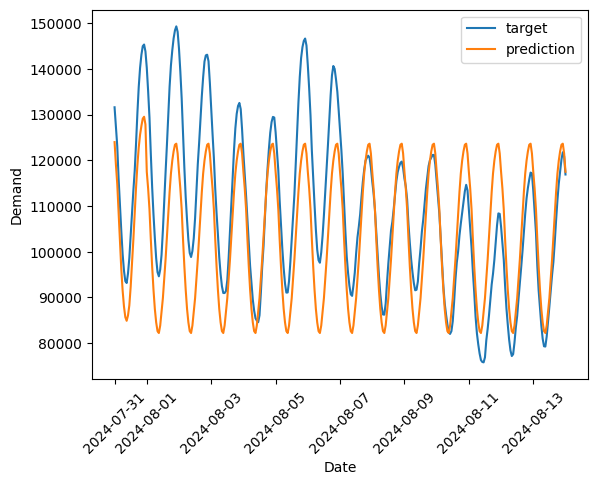

In [40]:
plt.plot(eval_df.index, eval_df.D, label='target')
plt.plot(eval_df.index, pred, label='prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Demand')
plt.legend()
plt.show()

# Log the model to mlflow

In [41]:
mlflow.set_tracking_uri(uri=os.getenv('MLFLOW_ENDPOINT_URI'))
with mlflow.start_run():
    mlflow_emit_tags_and_params(df, dvc_dataset_info)
    mlflow.pyfunc.log_model(artifact_path="baseline_model", python_model=baseline_model)

/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 21:57:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the 

# Visualize and Compare performance metrics over time

In [137]:
mlflow.set_tracking_uri(uri=os.getenv('MLFLOW_ENDPOINT_URI'))
#experiment_id = client.get_experiment_by_name('xgb.df.compare_models').experiment_id
runs = mlflow.search_runs(experiment_names=['xgb.df.compare_models'])
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mean_absolute_error,metrics.sum_on_target,metrics.mean_squared_error,metrics.mean_absolute_percentage_error,...,metrics.max_error,metrics.root_mean_squared_error,params.model_version,params.model_name,tags.mlflow.source.type,tags.mlflow.source.name,tags.prefect_flow_run,tags.mlflow.datasets,tags.mlflow.runName,tags.mlflow.user
0,41841436224c4e529030ece5177a7b3c,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/418414362...,2024-08-19 14:35:32.021000+00:00,2024-08-19 14:35:32.070000+00:00,6601.521280,35461589.0,7.696506e+07,0.061935,...,23596.115859,8772.973270,4,baseline,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,chi3-vandros,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",baseline-v4_eval,root
1,d5bcfdba40c740b0ae9853209fa2d53c,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/d5bcfdba4...,2024-08-19 14:35:31.530000+00:00,2024-08-19 14:35:31.592000+00:00,7069.766181,35461589.0,7.745326e+07,0.066933,...,19836.054688,8800.753413,2,xgboost-df,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,chi3-vandros,"[{""name"":""2ffe1882b827f52ce3dea481d93e4584"",""h...",xgboost-df-v2_eval,root
2,f96f1ec1442e464dbdc7915b099dae22,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/f96f1ec14...,2024-08-18 17:03:05.028000+00:00,2024-08-18 17:03:05.084000+00:00,7853.734930,35883585.0,1.056261e+08,0.071966,...,26939.242320,10277.458254,4,baseline,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,xi-dziban,"[{""name"":""cc3c05e214957603dd38cf04569736c4"",""h...",baseline-v4_eval,root
3,fdb04eddb12d479aa740e93471800032,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/fdb04eddb...,2024-08-18 17:03:04.103000+00:00,2024-08-18 17:03:04.340000+00:00,8358.497844,35883585.0,1.139252e+08,0.077044,...,29617.710938,10673.572757,2,xgboost-df,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,xi-dziban,"[{""name"":""cc3c05e214957603dd38cf04569736c4"",""h...",xgboost-df-v2_eval,root
4,a87fe7a8663d42d6b774ef9bccfb3d6f,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/a87fe7a86...,2024-08-17 03:49:13.421000+00:00,2024-08-17 03:49:13.467000+00:00,9153.565547,36336670.0,1.332876e+08,0.082350,...,26939.242320,11545.025667,4,baseline,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,delta2-calder-mass,"[{""name"":""b834cd2f7638cbc59a0eb69c2d2535ef"",""h...",baseline-v4_eval,root
5,a04f7ad1f0f54bb88a00cbf7f25730e3,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/a04f7ad1f...,2024-08-17 03:49:12.718000+00:00,2024-08-17 03:49:12.939000+00:00,9709.028375,36336670.0,1.445828e+08,0.087742,...,29617.710938,12024.260754,2,xgboost-df,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,delta2-calder-mass,"[{""name"":""b834cd2f7638cbc59a0eb69c2d2535ef"",""h...",xgboost-df-v2_eval,root
6,73b36ee1896f4510ade5e20ab6320b99,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/73b36ee18...,2024-08-17 03:46:29.094000+00:00,2024-08-17 03:46:29.161000+00:00,9153.565547,36336670.0,1.332876e+08,0.082350,...,26939.242320,11545.025667,4,baseline,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,nu6-zetar-point,"[{""name"":""b834cd2f7638cbc59a0eb69c2d2535ef"",""h...",baseline-v4_eval,root
7,6b728b27eb4c471d82c7caea49133a16,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/6b728b27e...,2024-08-17 03:46:27.827000+00:00,2024-08-17 03:46:28.076000+00:00,9709.028375,36336670.0,1.445828e+08,0.087742,...,29617.710938,12024.260754,2,xgboost-df,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,nu6-zetar-point,"[{""name"":""b834cd2f7638cbc59a0eb69c2d2535ef"",""h...",xgboost-df-v2_eval,root
8,b2e3006e9b0d45ea8db27adebbb689a5,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/b2e3006e9...,2024-08-17 03:45:14.272000+00:00,2024-08-17 03:45:14.472000+00:00,9153.565547,36336670.0,1.332876e+08,0.082350,...,26939.242320,11545.025667,4,baseline,LOCAL,

In [ ]:
# Cast some types
runs['start_time'] = pd.to_datetime(runs['start_time'], utc=True)
runs['params.model_version'] = pd.to_numeric(runs['params.model_version'])
runs['metrics.root_mean_squared_error'] = pd.to_numeric(runs['metrics.root_mean_squared_error'])

In [85]:
runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mean_absolute_error,metrics.sum_on_target,metrics.mean_squared_error,metrics.mean_absolute_percentage_error,...,metrics.max_error,metrics.root_mean_squared_error,params.model_version,params.model_name,tags.mlflow.source.type,tags.mlflow.source.name,tags.prefect_flow_run,tags.mlflow.datasets,tags.mlflow.runName,tags.mlflow.user
0,f96f1ec1442e464dbdc7915b099dae22,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/f96f1ec14...,2024-08-18 17:03:05.028000+00:00,2024-08-18 17:03:05.084000+00:00,7853.734930,35883585.0,1.056261e+08,0.071966,...,26939.242320,10277.458254,4,baseline,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,xi-dziban,"[{""name"":""cc3c05e214957603dd38cf04569736c4"",""h...",baseline-v4_eval,root
1,fdb04eddb12d479aa740e93471800032,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/fdb04eddb...,2024-08-18 17:03:04.103000+00:00,2024-08-18 17:03:04.340000+00:00,8358.497844,35883585.0,1.139252e+08,0.077044,...,29617.710938,10673.572757,2,xgboost-df,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,xi-dziban,"[{""name"":""cc3c05e214957603dd38cf04569736c4"",""h...",xgboost-df-v2_eval,root
2,a87fe7a8663d42d6b774ef9bccfb3d6f,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/a87fe7a86...,2024-08-17 03:49:13.421000+00:00,2024-08-17 03:49:13.467000+00:00,9153.565547,36336670.0,1.332876e+08,0.082350,...,26939.242320,11545.025667,4,baseline,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,delta2-calder-mass,"[{""name"":""b834cd2f7638cbc59a0eb69c2d2535ef"",""h...",baseline-v4_eval,root
3,a04f7ad1f0f54bb88a00cbf7f25730e3,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/a04f7ad1f...,2024-08-17 03:49:12.718000+00:00,2024-08-17 03:49:12.939000+00:00,9709.028375,36336670.0,1.445828e+08,0.087742,...,29617.710938,12024.260754,2,xgboost-df,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,delta2-calder-mass,"[{""name"":""b834cd2f7638cbc59a0eb69c2d2535ef"",""h...",xgboost-df-v2_eval,root
4,73b36ee1896f4510ade5e20ab6320b99,128223311134607822,FINISHED,mlflow-artifacts:/128223311134607822/73b36ee18...,2024-08-17 03:46:29.094000+00:00,2024-08-17 03:46:29.161000+00:00,9153.565547,36336670.0,1.332876e+08,0.082350,...,26939.242320,11545.025667,4,baseline,LOCAL,/usr/local/lib/python3.10/site-packages/prefec...,nu6-zetar-point,"[{""name"":""b834cd2f7638cbc59a0eb69c2d2535ef"",""h...",baseline-v4_eval,root


In [93]:
runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.mean_absolute_error', 'metrics.sum_on_target',
       'metrics.mean_squared_error', 'metrics.mean_absolute_percentage_error',
       'metrics.example_count', 'metrics.r2_score', 'metrics.mean_on_target',
       'metrics.max_error', 'metrics.root_mean_squared_error',
       'params.model_version', 'params.model_name', 'tags.mlflow.source.type',
       'tags.mlflow.source.name', 'tags.prefect_flow_run',
       'tags.mlflow.datasets', 'tags.mlflow.runName', 'tags.mlflow.user'],
      dtype='object')

In [129]:
def filter_runs(runs_df, model_name, model_version):
    mn_mask = runs_df['params.model_name'] == model_name
    mv_mask = runs_df['params.model_version'] == model_version
    return runs_df[mn_mask & mv_mask]

models = [MLFlowModelSpecifier(name='baseline', version=4), MLFlowModelSpecifier(name='xgboost-df', version=2)]

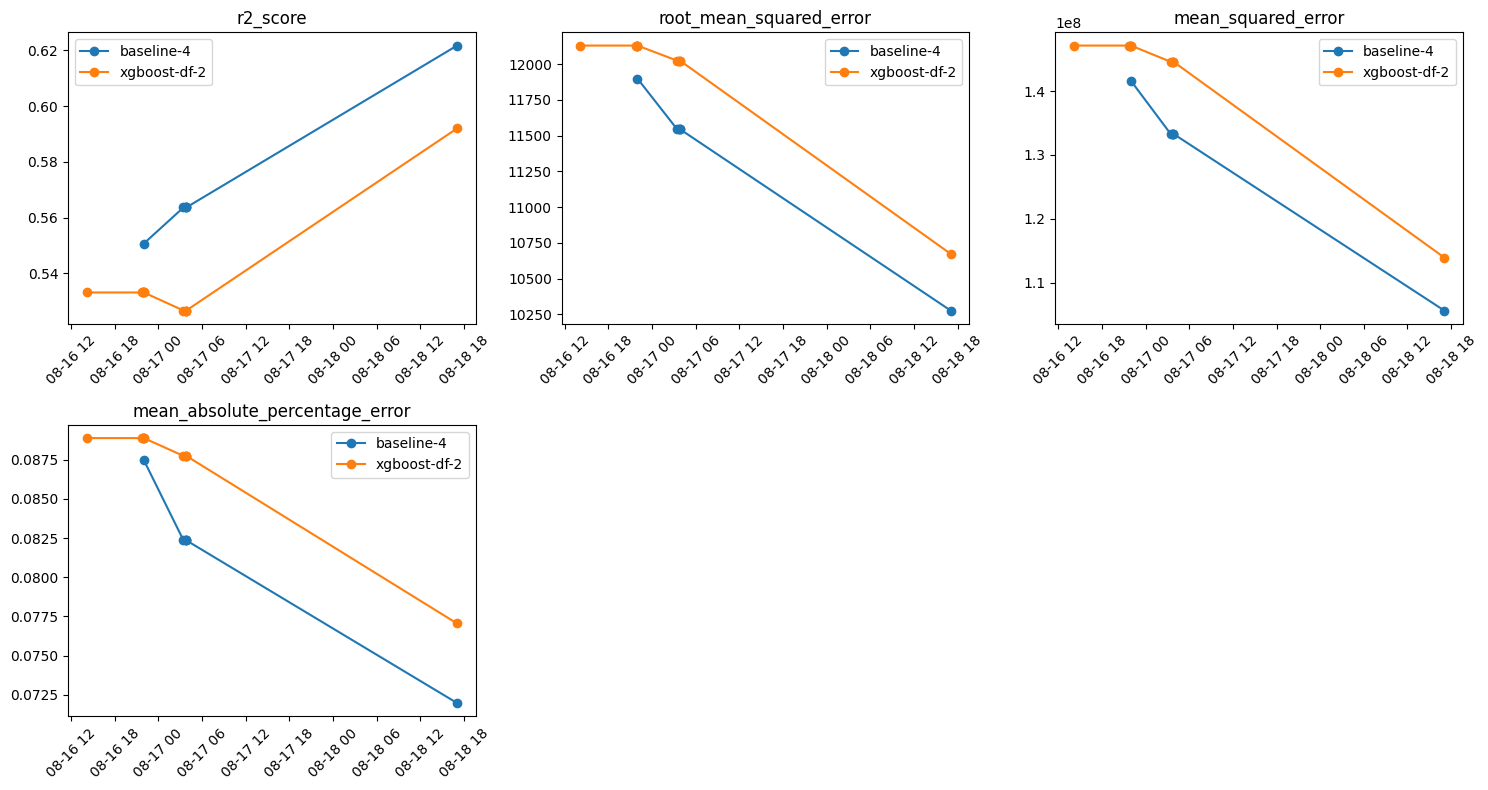

In [133]:
metrics = ['r2_score', 'root_mean_squared_error', 'mean_squared_error', 'mean_absolute_percentage_error']
num_cols = 3
num_rows = (len(metrics) // num_cols) + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axs = axs.flat
for m in models:
    model_runs_df = filter_runs(runs, m.name, m.version)
    for i, metric in enumerate(metrics):
        #print(f'model:{m.name}. metric:{metric}. data:{model_runs_df[f"metrics.{metric}"]}')
        axs[i].set_title(metric)
        axs[i].plot(model_runs_df.start_time, model_runs_df[f'metrics.{metric}'], 
                 marker='o', label=f'{m.name}-{m.version}')
        axs[i].legend()
        axs[i].tick_params(axis='x', rotation=45)
        
# Remove axes for any extra subplots beyond the number of metrics
for i in range(len(metrics), len(axs)):
    fig.delaxes(axs[i])
    
plt.tight_layout()
plt.show()

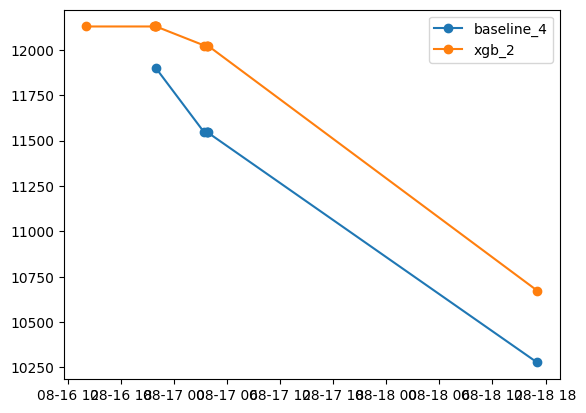

In [92]:
plt.plot(baseline_4_runs.start_time, baseline_4_runs['metrics.root_mean_squared_error'], 
         marker='o', label='baseline_4')
plt.plot(xgb_2_runs.start_time, xgb_2_runs['metrics.root_mean_squared_error'], 
         marker='o', label='xgb_2')
plt.legend()
plt.show()